In [12]:
import tensorflow as tf
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.layers import Dense, Embedding, Input, Add, Dot, Reshape, Flatten
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.sequence import skipgrams
from tensorflow.python.keras.models import Model, load_model
import sklearn
import array
import pickle
import tarfile
from urllib.request import urlretrieve
import os
import sys
from os import listdir
import nltk
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_distances
from os.path import isfile, join
from scipy.sparse import csr_matrix, lil_matrix
import numpy as np
from scipy.sparse import save_npz, load_npz
from tensorflow.python.keras import backend as K
import random
import matplotlib.pyplot as plt
from tensorflow.python.keras.utils import plot_model
import pandas as pd
%matplotlib inline

In [2]:
def getTextFromCooc(pathToFile):
    with open(pathToFile, 'r', encoding='utf8') as f:
        indexRow = 0
        headerText = []
        docs = []
        for row in f:
            if(indexRow == 0):
                for word in row.split(','):
                    headerText.append(word)
            else:
                indexNumber = 0
                isStringCreated = False
                for word2 in row.split(','):
                    if(indexNumber == 0):
                        pass
                    else:
                        if int(word2) == 1:
                            if(isStringCreated == False):
                                string = ''
                                isStringCreated = True
                            if(string == ""):
                                string = headerText[indexNumber-1]
                            else:
                                string = string +' '+headerText[indexNumber-1]
                    indexNumber += 1
                #string = string[2:]
                docs.append(string)
                docs = [s.replace("'", '"') for s in docs] # remove all the 8s 
            indexRow +=1
    with open('./docs/textTheGoodScents.txt','wb') as f:
        pickle.dump(docs, f)
    return [docs,headerText]

In [3]:
docs,headerText = getTextFromCooc('./TGS/dataTGS.csv')
#docs = [s.replace(" ", '') for s in docs]
docs = [s.replace('""', '" "') for s in docs]
headerText = headerText[1:]

In [4]:
def strip_first_col(fname, delimiter=','):
    with open(fname, 'r') as fin:
        for line in fin:
            try:
               yield line.split(delimiter, 1)[1]
            except IndexError:
               continue
array = np.loadtxt(strip_first_col('./TGS/dataTGS.csv'), delimiter=",", skiprows=1)
cooc_mat2 = np.dot(array.T,array)
print(cooc_mat2)

[[67.  0.  0. ...  0.  0.  0.]
 [ 0.  8.  0. ...  0.  0.  0.]
 [ 0.  0.  4. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... 28.  0.  0.]
 [ 0.  0.  0. ...  0.  2.  0.]
 [ 0.  0.  0. ...  0.  0. 40.]]


In [5]:
print(docs)

['anisé aubépine balsamique cerfeuil cerise doux fleurdacacia fruité poudré vanille', 'animal', 'amande balsamique essence floral plastique', 'amande balsamique essence floral plastique', 'amande balsamique cerise chimique doux floral fruité phénolé rose', 'amande boisé cerfeuil cerise doux fruitàcoque fruité huile poudré sucrebrûlé', 'ail café chou menthé oignon poireau raifort soufré tomate vert', 'acétone acrylate anis essence éther plastique', 'boisé café épicé sciure solvant', 'herbe', 'herbe', 'floral huile médicinal narcisse phénolé rhubarbe rose vert', 'ambregris boisé cèdre', 'bière frais levure', 'capucine coriandre fleurdetroëne floral ozone rose vert violette zesté\n', 'balsamique épicé fruité noixdemuscade vin', 'balsamique ciredabeille doux fruitàcoque gras huile vanille', 'baie doux herbe vert', 'ail alliacé beurre café ciboulette cuit légume oignon palourde vert', 'ail brûlé chimique', 'café', 'café', 'doux floral fruité miel papaye poudré vert', 'anisé épicé floral', '

In [6]:
v_size = len(headerText)
tokenizer = Tokenizer(num_words=v_size, oov_token='UNK')
tokenizer.fit_on_texts(docs)

In [7]:
generate_cooc = False
def generate_cooc_matrix(text, tokenizer, window_size, n_vocab, use_weighting=True):
    sequences = tokenizer.texts_to_sequences(text)
    meanLen = 0
    meanNumber = 0
    print(sequences)
    for sequence in sequences:
        meanLen += len(sequence)
        meanNumber +=1
    meanLen = meanLen/meanNumber
    window_size = round(meanLen)
    cooc_mat = lil_matrix((n_vocab, n_vocab), dtype=np.float32)
    for sequence in sequences:
        window_size = int(len(sequence)/2)
        if(len(sequence) % 2 == 0):
            for i, wi in zip(np.arange(window_size, len(sequence)-window_size+1), sequence[window_size-1:-window_size]):
                context_window = sequence[i-window_size: i+window_size+1]
                distances = np.abs(np.arange(-(window_size-1), window_size+1))
                distances[window_size] = 1.0
                nom = np.ones(shape=(window_size*2,), dtype=np.float32)
                nom[window_size-1] = 0.0
                if use_weighting:
                    cooc_mat[wi, context_window] += nom/distances    # Update element
                else:
                    for y in range(0,len(sequence)-1):
                        nom = np.ones(shape=(window_size*2,), dtype=np.float32)
                        nom[y] = 0.0
                        cooc_mat[sequence[y], context_window] += nom
        else:
            for i, wi in zip(np.arange(window_size, len(sequence)-window_size), sequence[window_size:-window_size]):
                context_window = sequence[i-window_size: i+window_size+1]
                distances = np.abs(np.arange(-window_size, window_size+1))
                distances[window_size] = 1.0
                nom = np.ones(shape=(window_size*2 + 1,), dtype=np.float32)
                nom[window_size] = 0.0
                if use_weighting:
                    cooc_mat[wi, context_window] += nom/distances    # Update element
                else:
                    for y in range(0,len(sequence)-1):
                        nom = np.ones(shape=(window_size*2 + 1,), dtype=np.float32)
                        nom[y] = 0.0
                        cooc_mat[sequence[y], context_window] += nom
    return cooc_mat    

if not generate_cooc:
    cooc_mat = generate_cooc_matrix(docs, tokenizer, 4, v_size, False)
    print("Generated......")
    cooc_mat
    save_npz(os.path.join('datasets','cooc_mat.npz'), cooc_mat.tocsr())
else:
    cooc_mat = load_npz(os.path.join('datasets','cooc_mat.npz')).tolil()
    print('Cooc matrix of type {} was loaded from disk'.format(type(cooc_mat).__name__))
    
print(cooc_mat)

[[106, 132, 13, 249, 62, 4, 229, 2, 20, 40], [53], [82, 13, 250, 5, 117], [82, 13, 250, 5, 117], [82, 13, 62, 99, 4, 5, 2, 26, 14], [82, 6, 249, 62, 4, 15, 2, 17, 20, 202], [48, 39, 113, 22, 36, 251, 142, 28, 118, 3], [280, 238, 94, 250, 41, 117], [6, 39, 8, 230, 125], [7], [7], [5, 17, 67, 126, 26, 190, 14, 3], [33, 6, 68], [203, 11, 138], [148, 107, 186, 5, 119, 14, 3, 57, 104], [13, 8, 2, 187, 43], [13, 9, 4, 15, 10, 17, 40], [21, 4, 7, 3], [48, 83, 50, 39, 317, 102, 18, 36, 281, 3], [48, 56, 99], [39], [39], [4, 5, 2, 31, 231, 20, 3], [106, 8, 5], [69, 5, 46, 71], [12, 37, 4, 2, 17, 24, 54, 125, 16], [12, 37, 4, 2, 17, 24, 54, 125, 16], [238, 25, 13, 81, 102, 4, 8, 2, 142, 63], [79, 5, 3], [2, 71], [2, 71], [74, 2, 23, 43], [12, 9, 5, 2, 76, 14, 3], [9, 186, 2, 10, 17, 55, 3], [97], [42, 2, 23, 143], [9, 4, 11, 100, 2, 38, 23, 3], [37, 6, 9, 8, 11, 2, 23, 3], [69, 4, 5, 2, 54], [297, 239, 240, 58, 44], [46, 103, 3], [53, 106, 132, 22, 16], [55], [55], [135], [21, 9, 8, 5, 11, 2, 7,

Generated......
  (1, 2)	1.0
  (1, 8)	1.0
  (1, 9)	1.0
  (1, 11)	1.0
  (1, 12)	1.0
  (1, 28)	1.0
  (1, 36)	1.0
  (1, 48)	1.0
  (1, 71)	1.0
  (1, 81)	1.0
  (1, 83)	1.0
  (1, 88)	1.0
  (1, 109)	1.0
  (1, 120)	1.0
  (1, 135)	1.0
  (1, 183)	1.0
  (1, 200)	1.0
  (1, 251)	1.0
  (2, 1)	1.0
  (2, 3)	466.0
  (2, 4)	426.0
  (2, 5)	266.0
  (2, 6)	146.0
  (2, 7)	184.0
  (2, 8)	130.0
  (2, 9)	210.0
  (2, 10)	161.0
  (2, 11)	119.0
  (2, 12)	115.0
  (2, 13)	77.0
  (2, 14)	99.0
  (2, 15)	55.0
  (2, 16)	58.0
  (2, 17)	103.0
  (2, 18)	79.0
  (2, 19)	88.0
  (2, 20)	74.0
  (2, 21)	136.0
  (2, 22)	37.0
  (2, 23)	152.0
  (2, 24)	59.0
  (2, 25)	116.0
  (2, 26)	35.0
  (2, 27)	17.0
  (2, 28)	26.0
  (2, 29)	36.0
  (2, 30)	40.0
  (2, 31)	58.0
  (2, 32)	70.0
  (2, 33)	15.0
  (2, 34)	69.0
  (2, 35)	38.0
  (2, 36)	18.0
  (2, 37)	90.0
  (2, 38)	84.0
  (2, 39)	12.0
  (2, 40)	30.0
  (2, 41)	73.0
  (2, 42)	45.0
  (2, 43)	72.0
  (2, 44)	22.0
  (2, 45)	39.0
  (2, 46)	38.0
  (2, 47)	37.0
  (2, 48)	7.0
  (2, 49)	42.0
  (2,

# TSNE SUR DONNEES BRUTES

[1.0, 1.0, 1.0, 1.0]
[0.5171427, 0.5177572, 0.5287088, 0.53890586]
[0.15979737, 0.16790116, 0.16790515, 0.17012793]
[0.18399096, 0.21257597, 0.240524, 0.2421565]
[0.14194995, 0.14751834, 0.15160012, 0.154059]
[0.13416803, 0.14362109, 0.14809906, 0.15223056]
[0.15340644, 0.15436083, 0.16385013, 0.16447389]
[0.0960294, 0.14809906, 0.15279037, 0.1622755]
[0.12723845, 0.13230675, 0.14362109, 0.14551449]
[0.104682624, 0.14078647, 0.14328909, 0.14492786]
[0.12910211, 0.13804448, 0.14558673, 0.17102134]
[0.0960294, 0.109749615, 0.11788815, 0.13230675]
[0.10337502, 0.109749615, 0.123107016, 0.1243121]
[0.11756587, 0.12260181, 0.15002358, 0.15539265]
[0.102828264, 0.123107016, 0.12550485, 0.13776582]
[0.18528485, 0.23353142, 0.23422831, 0.25135475]
[0.10690242, 0.11775851, 0.11901039, 0.14212489]
[0.09937847, 0.104682624, 0.107367456, 0.12150413]
[0.09709358, 0.10690242, 0.14671642, 0.15232712]
[0.17279577, 0.18547046, 0.19600207, 0.19785196]
[0.11756587, 0.12597227, 0.16620266, 0.17268944]
[0.

[t-SNE] Iteration 50: error = 60.7541809, gradient norm = 0.0000002 (50 iterations in 0.134s)
[t-SNE] Iteration 100: error = 60.7541809, gradient norm = 0.0000002 (50 iterations in 0.108s)
[t-SNE] Iteration 150: error = 60.7528839, gradient norm = 0.0000000 (50 iterations in 0.107s)
[t-SNE] Iteration 150: gradient norm 0.000000. Finished.
[t-SNE] KL divergence after 150 iterations with early exaggeration: 60.752884
[t-SNE] Iteration 200: error = 1.4321150, gradient norm = 0.0138657 (50 iterations in 0.105s)
[t-SNE] Iteration 250: error = 1.0057883, gradient norm = 0.0022894 (50 iterations in 0.142s)
[t-SNE] Iteration 300: error = 0.9377510, gradient norm = 0.0008769 (50 iterations in 0.128s)
[t-SNE] Iteration 350: error = 0.9137197, gradient norm = 0.0005090 (50 iterations in 0.132s)
[t-SNE] Iteration 400: error = 0.8999293, gradient norm = 0.0003451 (50 iterations in 0.142s)
[t-SNE] Iteration 450: error = 0.8944978, gradient norm = 0.0002187 (50 iterations in 0.137s)
[t-SNE] Iteration

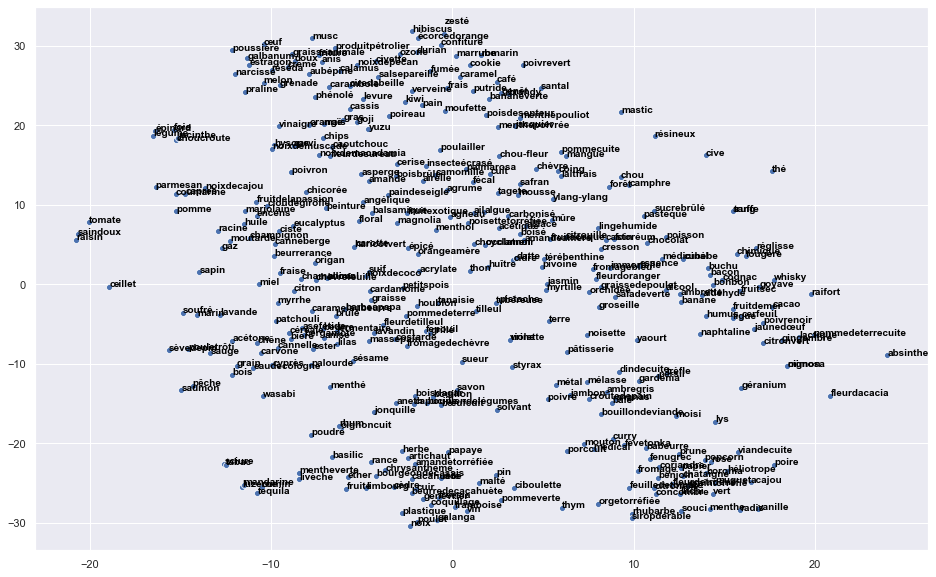

In [19]:
# calculer matrice et enlever diagonale (val à 0) trier chaque ligne en décroissant 
# et prendr les 4 premiers (vérifier si il y a des voisins lus proche > 1)
# a faire sur donnée centrée 
# -------------- DONE --------------
# regarder sur les données d'Oniris
# -------------- DONE --------------
# refaire 8-9 visu pr tsne avec données brutes (centré) en faisant varié les params 
# faire un cosinus sur les 150 premieres dimensions de l'ACP (prendre les n dimensions représentant 90% de l'info + faire tsn-e sur cette matrice)
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 10)

cooc_mat_cosine = cosine_distances(cooc_mat)

for row in cooc_mat_cosine:
    t = np.array(row)
    indices = t.argsort()
    indices = indices[t[indices] > 0]
    print([t[indices[0]],t[indices[1]],t[indices[2]],t[indices[3]]])

tsne = TSNE(n_components=2,metric='precomputed',verbose=2,n_iter=2000,perplexity=20,early_exaggeration = 12,learning_rate=10)
X_embedded = tsne.fit_transform(cooc_mat_cosine)


df_subset = {} 
df_subset['tsne-2d-one'] = X_embedded[:,0]
df_subset['tsne-2d-two'] = X_embedded[:,1]
plt.figure(figsize=(16,10))
p1 = sns.scatterplot(X_embedded[:,0], X_embedded[:,1], legend='full', palette=palette)
for line in range(0,cooc_mat.shape[0]):
     p1.text(df_subset['tsne-2d-one'][line]+0.01, df_subset['tsne-2d-two'][line], 
     headerText[line], horizontalalignment='left', 
     size='small', color='black', weight='semibold')

# TSNE SUR DONNEES BRUTES CENTREE REDUITE

[1.0, 1.0, 1.0, 1.0]
[0.5171427, 0.5177572, 0.5287088, 0.53890586]
[0.15979737, 0.16790116, 0.16790515, 0.17012793]
[0.18399096, 0.21257597, 0.240524, 0.2421565]
[0.14194995, 0.14751834, 0.15160012, 0.154059]
[0.13416803, 0.14362109, 0.14809906, 0.15223056]
[0.15340644, 0.15436083, 0.16385013, 0.16447389]
[0.0960294, 0.14809906, 0.15279037, 0.1622755]
[0.12723845, 0.13230675, 0.14362109, 0.14551449]
[0.104682624, 0.14078647, 0.14328909, 0.14492786]
[0.12910211, 0.13804448, 0.14558673, 0.17102134]
[0.0960294, 0.109749615, 0.11788815, 0.13230675]
[0.10337502, 0.109749615, 0.123107016, 0.1243121]
[0.11756587, 0.12260181, 0.15002358, 0.15539265]
[0.102828264, 0.123107016, 0.12550485, 0.13776582]
[0.18528485, 0.23353142, 0.23422831, 0.25135475]
[0.10690242, 0.11775851, 0.11901039, 0.14212489]
[0.09937847, 0.104682624, 0.107367456, 0.12150413]
[0.09709358, 0.10690242, 0.14671642, 0.15232712]
[0.17279577, 0.18547046, 0.19600207, 0.19785196]
[0.11756587, 0.12597227, 0.16620266, 0.17268944]
[0.

[t-SNE] Iteration 50: error = 61.9324226, gradient norm = 0.0000000 (50 iterations in 0.164s)
[t-SNE] Iteration 50: gradient norm 0.000000. Finished.
[t-SNE] KL divergence after 50 iterations with early exaggeration: 61.932423
[t-SNE] Iteration 100: error = 1.7579801, gradient norm = 0.0127788 (50 iterations in 0.152s)
[t-SNE] Iteration 150: error = 1.2178847, gradient norm = 0.0019736 (50 iterations in 0.122s)
[t-SNE] Iteration 200: error = 1.1408275, gradient norm = 0.0010440 (50 iterations in 0.123s)
[t-SNE] Iteration 250: error = 1.1066755, gradient norm = 0.0005786 (50 iterations in 0.126s)
[t-SNE] Iteration 300: error = 1.0933425, gradient norm = 0.0003558 (50 iterations in 0.119s)
[t-SNE] Iteration 350: error = 1.0861338, gradient norm = 0.0002468 (50 iterations in 0.119s)
[t-SNE] Iteration 400: error = 1.0818923, gradient norm = 0.0002064 (50 iterations in 0.129s)
[t-SNE] Iteration 450: error = 1.0785587, gradient norm = 0.0002526 (50 iterations in 0.128s)
[t-SNE] Iteration 500

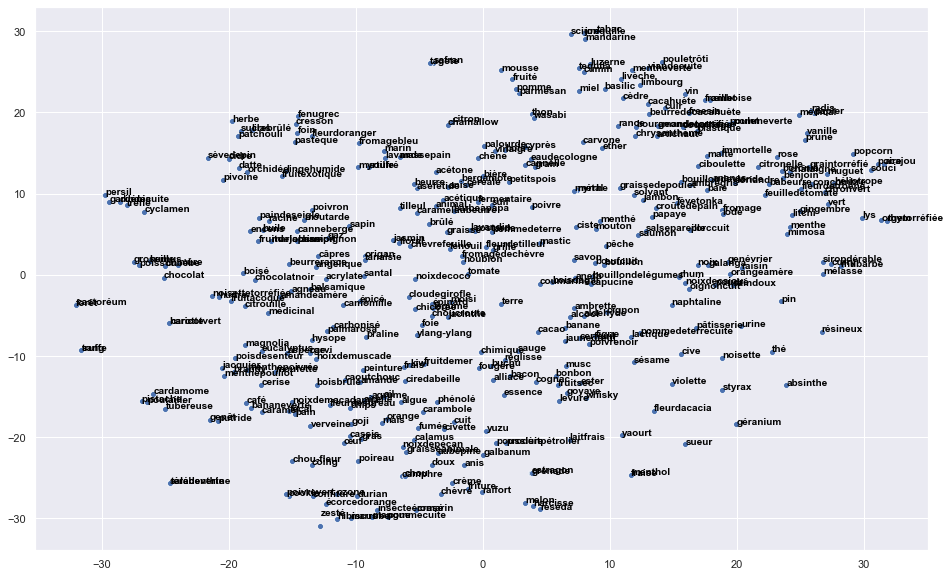

In [20]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
Z = sc.fit_transform(cooc_mat)

sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 10)

cooc_mat_cosine = cosine_distances(cooc_mat)

for row in cooc_mat_cosine:
    t = np.array(row)
    indices = t.argsort()
    indices = indices[t[indices] > 0]
    print([t[indices[0]],t[indices[1]],t[indices[2]],t[indices[3]]])

tsne = TSNE(n_components=2,metric='cosine',verbose=2,n_iter=2000,perplexity=20,early_exaggeration = 12,learning_rate=10)
X_embedded = tsne.fit_transform(Z.toarray())
df_subset = {} 
df_subset['tsne-2d-one'] = X_embedded[:,0]
df_subset['tsne-2d-two'] = X_embedded[:,1]
plt.figure(figsize=(16,10))

p1 = sns.scatterplot(X_embedded[:,0], X_embedded[:,1], legend='full', palette=palette)
for line in range(0,Z.shape[0]):
     p1.text(df_subset['tsne-2d-one'][line]+0.01, df_subset['tsne-2d-two'][line], 
     headerText[line], horizontalalignment='left', 
     size='small', color='black', weight='semibold')

  (0, 2)	1.0
  (0, 3)	4.0
  (0, 4)	11.0
  (0, 6)	2.0
  (0, 7)	4.0
  (0, 8)	2.0
  (0, 13)	1.0
  (0, 15)	1.0
  (0, 18)	5.0
  (0, 26)	1.0
  (0, 28)	1.0
  (0, 35)	7.0
  (0, 39)	6.0
  (0, 44)	1.0
  (0, 52)	1.0
  (0, 56)	4.0
  (0, 63)	1.0
  (0, 65)	1.0
  (0, 70)	1.0
  (0, 77)	5.0
  (0, 81)	1.0
  (0, 87)	1.0
  (0, 98)	1.0
  (0, 110)	1.0
  (0, 120)	1.0
  (0, 170)	1.0
  (0, 178)	2.0
  (0, 202)	5.0
  (0, 220)	3.0
  (0, 221)	5.0
  (0, 226)	7.0
  (0, 241)	1.0
  (0, 244)	2.0
  (0, 355)	1.0
2
[[  0.   1.   0. 466. 426. 266. 146. 184. 130. 210. 161. 119. 115.  77.
   99.  55.  58. 103.  79.  88.  74. 136.  37. 152.  59. 116.  35.  17.
   26.  36.  40.  58.  70.  15.  69.  38.  18.  90.  84.  12.  30.  73.
   45.  72.  22.  39.  38.  37.   7.  42.  32.  23.  17.  14.  68.  25.
   14.  36.  14.   7.  23.   9.  52.  54.  13.  16.  26.   9.   6.  44.
   26.  40.  12.   6.  40.   6.  19.  14.  50.  16.   8.  41.  20.   7.
   33.  18.  34.  17.  11.   3.   3.  10.   2.   4.   9.  11.   5.  17.
    8.  14. 

([<matplotlib.axis.XTick at 0x23b5c0b4588>,
 <a list of 25 Text xticklabel objects>)

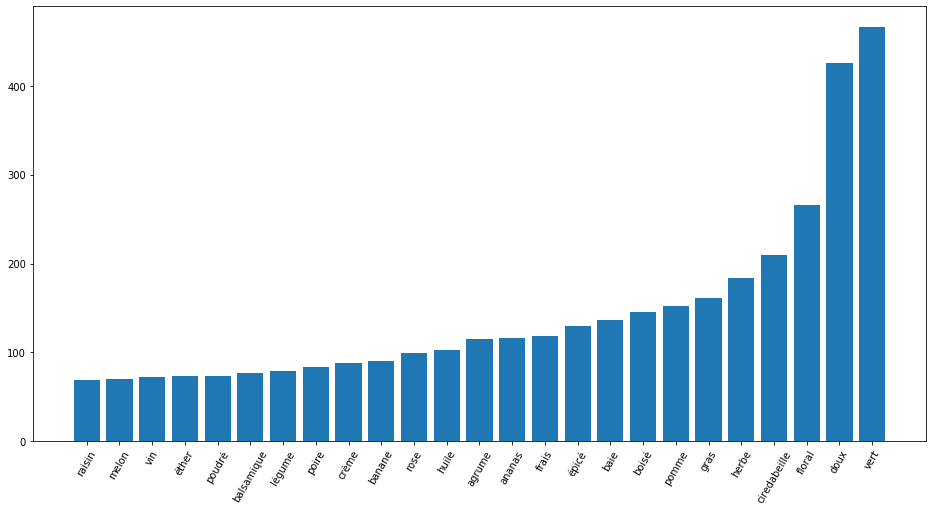

In [7]:
word="fruité"
assert word in tokenizer.word_index, 'Word {} is not in the tokenizer'.format(word)
assert tokenizer.word_index[word] <= v_size, 'The word {} is an out of vocabuary word. Please try something else'.format(word)

rev_word_index = dict(zip(tokenizer.word_index.values(), tokenizer.word_index.keys()))

#cooc_vec = np.array(cooc_mat.getrow(tokenizer.word_index[word]).todense()).ravel()
cooc_vec = np.array(cooc_mat.getrow(2).todense()).ravel()
print(cooc_mat.getrow(122))
print(tokenizer.word_index[word])
print(cooc_mat.getrow(tokenizer.word_index[word]).todense())
max_ind = np.argsort(cooc_vec)[-25:]
print(max_ind)
plt.figure(figsize=(16,8))
print(cooc_vec)
plt.bar(np.arange(0, 25), cooc_vec[max_ind])
plt.xticks(ticks=np.arange(0, 25), labels=[rev_word_index[i] for i in max_ind], rotation=60)

In [22]:
def create_glove_model(v_size):    
    w_i = Input(shape=(1,))
    w_j = Input(shape=(1,))

    emb_i = Flatten()(Embedding(v_size, 20, input_length=1)(w_i))
    emb_j = Flatten()(Embedding(v_size, 20, input_length=1)(w_j))

    ij_dot = Dot(axes=-1)([emb_i,emb_j])
    
    b_i = Flatten()(
        Embedding(v_size, 1, input_length=1)(w_i)
    )
    b_j = Flatten()(
        Embedding(v_size, 1, input_length=1)(w_j)
    )

    pred = Add()([ij_dot, b_i, b_j])

    def glove_loss(y_true, y_pred):
        return K.sum(
            K.pow((y_true-1)/100.0, 0.75)*K.square(y_pred - K.log(y_true))
        )

    model = Model(inputs=[w_i, w_j],outputs=pred)
    model.compile(loss=glove_loss, optimizer =Adam(lr=0.0001))
    return model


In [23]:
K.clear_session()
model = create_glove_model(v_size)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 20)        7600        input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 20)        7600        input_2[0][0]                    
______________________________________________________________________________________________

In [24]:
cooc_mat = load_npz(os.path.join('datasets','cooc_mat.npz'))
print(cooc_mat.shape)
batch_size = 60
copy_docs = list(docs)
index2word = dict(zip(tokenizer.word_index.values(), tokenizer.word_index.keys()))
""" Each epoch """
for ep in range(10):
    
    #valid_words = get_valid_words(docs, 20, tokenizer)
    
    random.shuffle(copy_docs)
    losses = []
    """ Each document (i.e. movie plot) """
    for doc in copy_docs:
        
        seq = tokenizer.texts_to_sequences([doc])[0]

        """ Getting skip-gram data """
        # Negative samples are automatically sampled by tf loss function
        wpairs, labels = skipgrams(
            sequence=seq, vocabulary_size=v_size, negative_samples=0.0, shuffle=True
        )
        
        if len(wpairs)==0:
            continue

        sg_in, sg_out = zip(*wpairs)
        sg_in, sg_out = np.array(sg_in).reshape(-1,1), np.array(sg_out).reshape(-1,1)
        x_ij = np.array(cooc_mat[sg_in[:,0], sg_out[:,0]]).reshape(-1,1) + 1
        
        assert np.all(np.array(labels)==1)
        assert x_ij.shape[0] == sg_in.shape[0], 'X_ij {} shape does not sg_in {}'.format(x_ij.shape, sg_in.shape)
        """ For each batch in the dataset """
        model.fit([sg_in, sg_out], x_ij, batch_size = batch_size, epochs=1, verbose=0)
        l = model.evaluate([sg_in, sg_out], x_ij, batch_size=batch_size, verbose=0)
        losses.append(l)
    print('Loss in epoch {}: {}'.format(ep, np.mean(losses)))

(54, 54)


C:\Users\Sebastien\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


IndexError: index (126) out of range

In [25]:
def save_embeddings(model,save_dir, tok, v_size):
    """ Saving data to disk """
    
    # We need to add the 0th index to word list manually
    word_list = ["RESERVED"]+[tok.index_word[w_i] for w_i in range(1,v_size)]
    emb_w_df = None
    for layer in model.layers:
        if 'embedding' == layer.name or 'embedding_1' == layer.name:
            if emb_w_df is None:
                emb_w_df = pd.DataFrame(layer.get_weights()[0])
            else:
                emb_w_df += layer.get_weights()[0]
    
    emb_w_df.insert(0, "word", word_list)
            
    emb_w_df.to_csv(
        os.path.join(save_dir, 'TGSembeddings_w.csv'), index=False, header=None
    )
    
save_embeddings(model, 'datasets', tokenizer, v_size)
model.save('glove_model.h5')

RuntimeError: Unable to create link (name already exists)

In [26]:
from sklearn.metrics.pairwise import cosine_similarity
def get_valid_words(docs, size, tok):
    """ Get a random set of words to check the embeddings """
    np.random.seed(120)
    valid_docs = np.random.choice(docs, size=size//2)
    valid_words = []
    for doc in valid_docs:
        np.random.seed(100)
        words = np.random.choice(tok.texts_to_sequences([doc])[0],size=2)
        valid_words.extend(words)
        
    return valid_words
        
valid_words = get_valid_words(docs, 10, tokenizer)
def load_embeddings(filename):
    print('Loading the word embeddings from the disk')
    embed_df = pd.read_csv(filename, index_col=False, header=None)
    embed_df = embed_df.set_index(0)
    print('Embedding shape: {}'.format(embed_df.shape))
    embed_mat = embed_df.values
    words = embed_df.index.values
    return embed_mat, words

def get_cosine_sim(emb, valid_words, top_k):
    norm = np.sqrt(np.sum(emb**2,axis=1,keepdims=True))
    norm_emb = emb/norm
    in_emb = norm_emb[valid_words,:]
    similarity = np.dot(in_emb, np.transpose(norm_emb))
    sorted_ind = np.argsort(-similarity, axis=1)[:,1:top_k+1]
    print(sorted_ind)
    return sorted_ind, valid_words

embed_mat, words = load_embeddings(os.path.join('datasets','TGSembeddings_w.csv'))
print(embed_mat)
print(words)
best_ids, wids = get_cosine_sim(embed_mat, valid_words, 5)
pd.Series(words).to_csv(os.path.join('datasets','index2word.csv'))
for w, bi in zip(wids, best_ids):
    print("{}: {}".format(words[w], ', '.join(words[bii] for bii in bi)))
    print("Classement des similaritées cosine :")
    for b in bi:
        print(cosine_similarity([embed_mat[w]],[embed_mat[b]]))
    

Loading the word embeddings from the disk
Embedding shape: (380, 20)
[[-0.04676678  0.0080306   0.04066131 ... -0.0061219  -0.00517846
  -0.00823162]
 [-0.04847981 -0.08346449 -0.01870072 ...  0.04705644 -0.03329384
   0.05285041]
 [-0.0003909   0.00931505  0.04500496 ... -0.00728191  0.02163972
  -0.05528557]
 ...
 [ 0.00510734  0.03886828  0.01973026 ...  0.02670167  0.01453687
   0.01659819]
 [-0.02188179  0.01982582  0.03086074 ... -0.03066071  0.02523614
   0.01717138]
 [-0.0109972  -0.03610338  0.01089954 ... -0.04865228 -0.03677984
   0.02422522]]
['RESERVED' 'UNK' 'fruité' 'vert' 'doux' 'floral' 'boisé' 'herbe' 'épicé'
 'ciredabeille' 'gras' 'frais' 'agrume' 'balsamique' 'rose' 'fruitàcoque'
 'terre' 'huile' 'légume' 'crème' 'poudré' 'baie' 'menthé' 'pomme' 'moisi'
 'ananas' 'phénolé' 'camphre' 'soufré' 'aldéhyde' 'métal' 'miel' 'melon'
 'ambregris' 'raisin' 'caramel' 'oignon' 'banane' 'poire' 'café' 'vanille'
 'éther' 'fromage' 'vin' 'tabac' 'noixdecoco' 'jasmin' 'savon' 'ail'

C:\Users\Sebastien\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


Loading the word embeddings from the disk
Embedding shape: (380, 20)
[[0.         0.92198608 1.13345684 ... 1.22028171 0.90197815 0.9884402 ]
 [0.92198608 0.         1.14667342 ... 1.20852826 1.14389856 0.79611141]
 [1.13345684 1.14667342 0.         ... 1.30981827 0.43887255 0.74981072]
 ...
 [1.22028171 1.20852826 1.30981827 ... 0.         1.26679437 1.3422317 ]
 [0.90197815 1.14389856 0.43887255 ... 1.26679437 0.         0.79910643]
 [0.9884402  0.79611141 0.74981072 ... 1.3422317  0.79910643 0.        ]]
(380, 380)
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 380 samples in 0.000s...
[t-SNE] Computed neighbors for 380 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 380 / 380
[t-SNE] Mean sigma: 0.232463
[t-SNE] Computed conditional probabilities in 0.008s
[t-SNE] Iteration 50: error = 72.6954727, gradient norm = 0.0000000 (50 iterations in 0.142s)
[t-SNE] Iteration 50: gradient norm 0.000000. Finished.
[t-SNE] KL divergence after 50 iterations

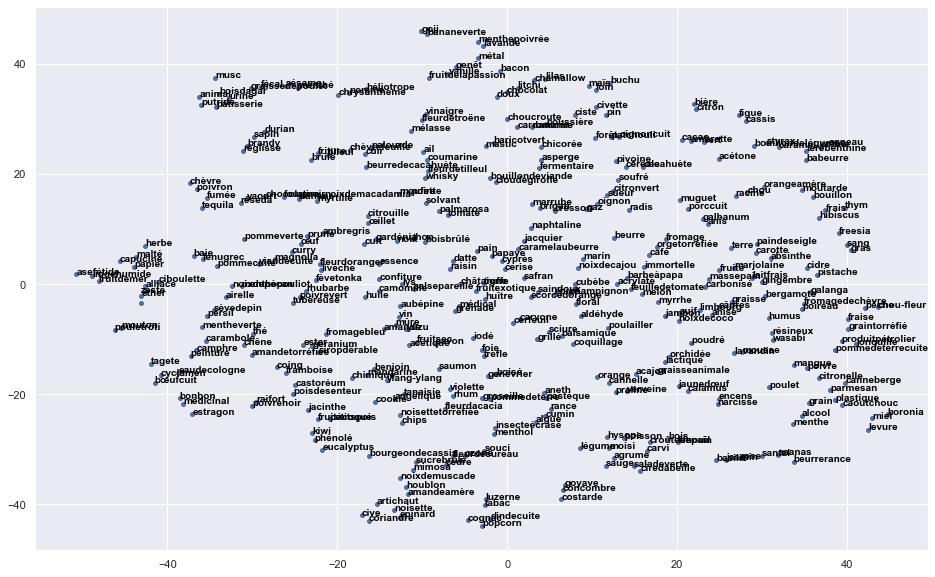

In [29]:

sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 10)
def getCosineMatrix(emb):
    matrix = pairwise_distances(emb, metric='cosine', n_jobs=-1)
    return np.abs(matrix)
embed_mat, words = load_embeddings(os.path.join('datasets','TGSembeddings_w.csv'))
cosine_matrix = getCosineMatrix(embed_mat)

cosine_matrix2 = cosine_distances(embed_mat)
print(cosine_matrix2)
#print(cosine_matrix)
print(cosine_matrix.shape)

#tsne = TSNE(n_components=2,metric='precomputed',verbose=2,n_iter=2000,perplexity=15,early_exaggeration = 6)

listBatch = [20,30,40]
listPerplexity = [10,5,20]
listLearningRate = [12,6]
listEarlyExa = [10,20]
listTsne = []

'''for per in listPerplexity:
    tsne = TSNE(n_components=2,metric='precomputed',verbose=2,n_iter=2000,perplexity=per,learning_rate=500)
    listTsne.append(tsne)
    X_embedded = tsne.fit_transform(cosine_matrix)'''

'''for learnin in listLearningRate:
    tsne = TSNE(n_components=2,metric='precomputed',verbose=2,n_iter=2000,perplexity=15,learning_rate=learnin)
    listTsne.append(tsne)
    X_embedded = tsne.fit_transform(cosine_matrix)'''
'''for early in listEarlyExa:
    tsne = TSNE(n_components=2,metric='precomputed',verbose=2,n_iter=2000,perplexity=5,learning_rate=learnin)
    listTsne.append(tsne)
    X_embedded = tsne.fit_transform(cosine_matrix)'''

tsne = TSNE(n_components=2,metric='precomputed',verbose=2,n_iter=2000,perplexity=10,early_exaggeration = 12,learning_rate=10)
X_embedded = tsne.fit_transform(cosine_matrix2)
df_subset = {} 
df_subset['tsne-2d-one'] = X_embedded[:,0]
df_subset['tsne-2d-two'] = X_embedded[:,1]
plt.figure(figsize=(16,10))
p1 = sns.scatterplot(X_embedded[:,0], X_embedded[:,1], legend='full', palette=palette)
for line in range(0,embed_mat.shape[0]):
     p1.text(df_subset['tsne-2d-one'][line]+0.01, df_subset['tsne-2d-two'][line], 
     headerText[line], horizontalalignment='left', 
     size='small', color='black', weight='semibold')



In [24]:
from sklearn.datasets import load_digits
X, y = load_digits(return_X_y=True)
print(X)
X.shape
y.shape


[[ 0.  0.  5. ...  0.  0.  0.]
 [ 0.  0.  0. ... 10.  0.  0.]
 [ 0.  0.  0. ... 16.  9.  0.]
 ...
 [ 0.  0.  1. ...  6.  0.  0.]
 [ 0.  0.  2. ... 12.  0.  0.]
 [ 0.  0. 10. ... 12.  1.  0.]]


(1797,)

breaking at iteration 162 with stress 311.7978458830855
breaking at iteration 228 with stress 315.08332932849396
breaking at iteration 131 with stress 319.41375630635014
breaking at iteration 182 with stress 309.6697985023701
breaking at iteration 148 with stress 332.1531798291998
breaking at iteration 267 with stress 333.04871809681583
breaking at iteration 238 with stress 347.02052342879256
breaking at iteration 179 with stress 373.93182273935645
breaking at iteration 294 with stress 306.0989296550289
(380, 2)


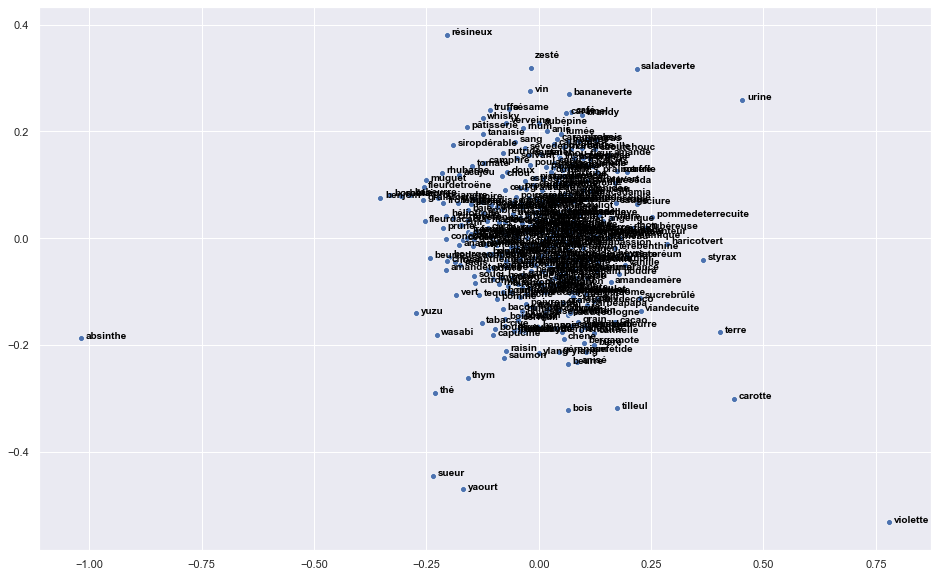

In [37]:
from sklearn.manifold import MDS
embedding = MDS(n_components=2,verbose=1,dissimilarity='precomputed',n_init=10)
X_transformed = embedding.fit_transform(cosine_matrix)
print(X_transformed.shape)


df_subset2 = {} 
df_subset2['mds-2d-one'] = X_transformed[:,0]
df_subset2['mds-2d-two'] = X_transformed[:,1]
plt.figure(figsize=(16,10))
p2 = sns.scatterplot(X_transformed[:,0], X_transformed[:,1], legend='full', palette=palette)
for line in range(0,embed_mat.shape[0]):
     p2.text(df_subset2['mds-2d-one'][line]+0.01, df_subset2['mds-2d-two'][line], 
     headerText[line], horizontalalignment='left', 
     size='small', color='black', weight='semibold')
